# CHROMOSOME VALIDATION

In [ ]:
import numpy as np
import pandas as pd
from math import log

def generate_dataset(
        num_stocks=500, start="2024-01-01", end="2024-01-31", freq="D"
    ):
        # Create a date range for all days in January
        date_range = pd.date_range(start=start, end=end, freq=freq)
        data = []
        for date in date_range:
            row = [date] + list(
                np.random.randint(100, 501, size=num_stocks)
            )
            data.append(row)
        columns = ["Date"] + [str(i) for i in range(1, num_stocks + 1)]
        df = pd.DataFrame(data, columns=columns)
        return df

# Approach inicial totalmente aleatorio, que no es factible   
def generate_chromosome(january,n_assets = 500, n_days = 31):
        valid = False
        while not valid :
            chromosome = np.random.randint(-10, 10, size=(n_assets, n_days))  # Cantidades aleatorias
            valid = check_chromosome(january,chromosome)
            print(chromosome,valid)
        return chromosome
    

def generate_chromosome(january, n_assets=500, n_days=31, initial_capital=10000):
    valid = False
    while not valid:
        chromosome = np.zeros((n_assets, n_days), dtype=int)  # Inicializar cromosoma en 0
        total_capital = initial_capital  # Capital inicial
        stocks_held = np.zeros(n_assets, dtype=int)  # Número de acciones que poseemos por activo

        for day in range(n_days):
            for asset in range(n_assets):
                # Precio del activo actual en el día actual
                asset_price = january.iloc[day, asset]
                
                # Probabilidad de tomar cada acción (hold, buy, sell)
                action_prob = np.random.rand()

                # Acción de "holdear" (probabilidad 33%)
                if action_prob < 1/3:
                    chromosome[asset, day] = 0  # No hacer nada
                # Acción de "comprar" (probabilidad 33%)
                elif action_prob < 2/3:  
                    if total_capital >= asset_price:  # Solo comprar si tenemos suficiente capital
                        max_buy = total_capital // asset_price  # Máximo que podemos comprar
                    
                        max_buy = log(max_buy)
                        if max_buy <1 :
                            max_buy = 1
                        
                        quantity = np.random.randint(1, max_buy + 1)  # Comprar una cantidad aleatoria
                        chromosome[asset, day] = quantity  # Registrar compra
                        stocks_held[asset] += quantity  # Actualizar número de acciones
                        total_capital -= quantity * asset_price  # Descontar el capital usado
                # Acción de "vender" (probabilidad 33%)
                else:  
                    if stocks_held[asset] > 0:  # Solo vender si poseemos acciones de este activo
                        max_sell = stocks_held[asset]  # No podemos vender más de lo que tenemos
                        quantity = np.random.randint(1, max_sell + 1)  # Vender una cantidad aleatoria
                        chromosome[asset, day] = -quantity  # Registrar venta
                        stocks_held[asset] -= quantity  # Actualizar número de acciones restantes
                        total_capital += quantity * asset_price  # Aumentar el capital con la venta

            # Verificar que el capital no sea negativo al final del día
            if total_capital < 0:
                break  # Salir del bucle si el capital es negativo
        
        # Ensure all remaining stocks are sold on the last day
        for asset in range(n_assets):
            if stocks_held[asset] > 0:  # If there are remaining stocks
                last_day_price = january.iloc[n_days - 1, asset]  # Price on the last day
                chromosome[asset, n_days - 1] = -stocks_held[asset]  # Sell all remaining stocks
                total_capital += stocks_held[asset] * last_day_price  # Update total capital
                stocks_held[asset] = 0  # Clear remaining stocks
               
        # Validamos si el cromosoma es válido
        valid = check_chromosome(january, chromosome)  # Validar el cromosoma

    return chromosome



def check_all_stocks_sold(chromosome, end_date_index=30):
    """
    Checks if all stocks have been sold by the last day of the period.

    Parameters:
    - chromosome: numpy array with decisions to buy/sell/hold.
    - end_date_index: Index of the last day of the period (default is 30, cause there are 31 days in January).

    Returns:
    - bool: True if no stocks are left, False otherwise.
    """
    stocks_held = np.sum(chromosome[:, end_date_index], axis=0)
    all_sold = np.all(stocks_held == 0)
    
    return all_sold
   
    
def aux_check_chromosome_has_previous_stocks(chromosome) :
    for stock in range(chromosome.shape[0]):
        value = 0
        for day in range(chromosome.shape[1]):
            value += chromosome[stock][day]
            if value < 0 : 
                return False
    return True

def check_chromosome(january,chromosome) :
    total = 10000
    day_sold = 0
    if np.any(chromosome[:, 0] < 0) : # Can´t sell in the first day 
        print("Can´t sell in the first day ")
        return False
    if not aux_check_chromosome_has_previous_stocks(chromosome) : # before selling stocks we must own them
        print("Before selling stocks we must own them")
        return False
    if not check_all_stocks_sold(chromosome):
        print("All stocks must have been sold by the last day of the period.")
        return False
    
    for active_index in range(chromosome.shape[1]): # Iterate through columns(days)
        day_sold,day_spent = 0,0
       
        
        if np.any(chromosome[:, active_index] < 1): # If it decides to sell
            negative_indexes = np.where(chromosome[:, active_index] < 0)[0]
            for index in negative_indexes :
                day_sold +=  chromosome[index][active_index] * january.iloc[active_index, index ] # Date column is taken into account so +1
        total_before = total  
        total -= day_spent + day_sold 
        
        if np.any(chromosome[:, active_index] > 1): # If it decides to buy
            positive_indexes = np.where(chromosome[:, active_index] > 0)[0]
            for index in positive_indexes :
                day_spent +=  chromosome[index][active_index] * january.iloc[active_index, index ] # Date column is taken into account so +1
            
            if day_spent > total  : # Cannot spend more than you have. We first buy, then we can sell.
                print(f"Cannot spend more than you have.")
                return False
            
        if total < 0:  
            print(f"total<0 : {total} = {total_before} - {day_spent} + {day_sold}")  
            return False  
        # print(f"Day spent : {day_spent} > total : {total}")
        # print(f"TOTAL: {total},DAY_SOLD: {abs(day_sold)}, DAY_SPENT : {-day_spent}")
    return True

# chromosome = np.array([
#     [0, 0, 5],
#     [-5, 0, 0],
#     [0, 15, -5],
#     [6, -5, 0],
#     [20, 0, 0]
# ]).T
# # Ejemplo simple de enero (31 días) para 3 activos
# january = pd.DataFrame({
#     1: [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130],
#     2: [200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230],
#     3: [300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330]
# })
# print(chromosome)
# print(january.head(),january.shape)
# #january = pd.read_csv("data/data.csv")
# print(check_chromosome(january,chromosome))

# Multi-threading(en desarrollo)

In [ ]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor
from math import log

def generate_single_chromosome(january, n_assets, n_days, initial_capital):
    valid = False
    i = 1
    while not valid:
        chromosome = np.zeros((n_assets, n_days), dtype=int)  # Inicializar cromosoma en 0
        total_capital = initial_capital  # Capital inicial
        stocks_held = np.zeros(n_assets, dtype=int)  # Número de acciones que poseemos por activo

        for day in range(n_days):
            for asset in range(n_assets):
                # Precio del activo actual en el día actual
                asset_price = january.iloc[day, asset]
                
                # Probabilidad de tomar cada acción (hold, buy, sell)
                action_prob = np.random.rand()

                # Acción de "holdear" (probabilidad 33%)
                if action_prob < 1/3:
                    chromosome[asset, day] = 0  # No hacer nada
                # Acción de "comprar" (probabilidad 33%)
                elif action_prob < 2/3:  
                    if total_capital >= asset_price:  # Solo comprar si tenemos suficiente capital
                        max_buy = total_capital // asset_price  # Máximo que podemos comprar
                    
                        max_buy = log(max_buy)
                        if max_buy <1 :
                            max_buy = 1
                        
                        quantity = np.random.randint(1, max_buy + 1)  # Comprar una cantidad aleatoria
                        chromosome[asset, day] = quantity  # Registrar compra
                        stocks_held[asset] += quantity  # Actualizar número de acciones
                        total_capital -= quantity * asset_price  # Descontar el capital usado
                # Acción de "vender" (probabilidad 33%)
                else:  
                    if stocks_held[asset] > 0:  # Solo vender si poseemos acciones de este activo
                        max_sell = stocks_held[asset]  # No podemos vender más de lo que tenemos
                        quantity = np.random.randint(1, max_sell + 1)  # Vender una cantidad aleatoria
                        chromosome[asset, day] = -quantity  # Registrar venta
                        stocks_held[asset] -= quantity  # Actualizar número de acciones restantes
                        total_capital += quantity * asset_price  # Aumentar el capital con la venta

            # Verificar que el capital no sea negativo al final del día
            if total_capital < 0:
                break  # Salir del bucle si el capital es negativo
            if i<1 :
                print(chromosome)
        # Validamos si el cromosoma es válido
            i+=1
        valid = check_chromosome(january, chromosome)  # Validar el cromosoma

    return chromosome

# def generate_chromosome(january, n_assets=500, n_days=31, initial_capital=10000, num_workers=8):
#     valid_chromosome = None

#     def check_and_return_chromosome(chromosome):
#         if check_chromosome(january, chromosome):
#             return chromosome
#         return None

#     with ProcessPoolExecutor(max_workers=num_workers) as executor:
#         while valid_chromosome is None:
#             # Crear cromosomas en paralelo
#             futures = [executor.submit(generate_single_chromosome, january, n_assets, n_days, initial_capital) for _ in range(num_workers)]
#             for future in futures:
#                 result = future.result()
#                 print(result)
#                 if check_and_return_chromosome(result):
#                     valid_chromosome = result
#                     break

#     return valid_chromosome


In [10]:
c = generate_chromosome(generate_dataset().drop(columns=['Date']),n_assets=500)

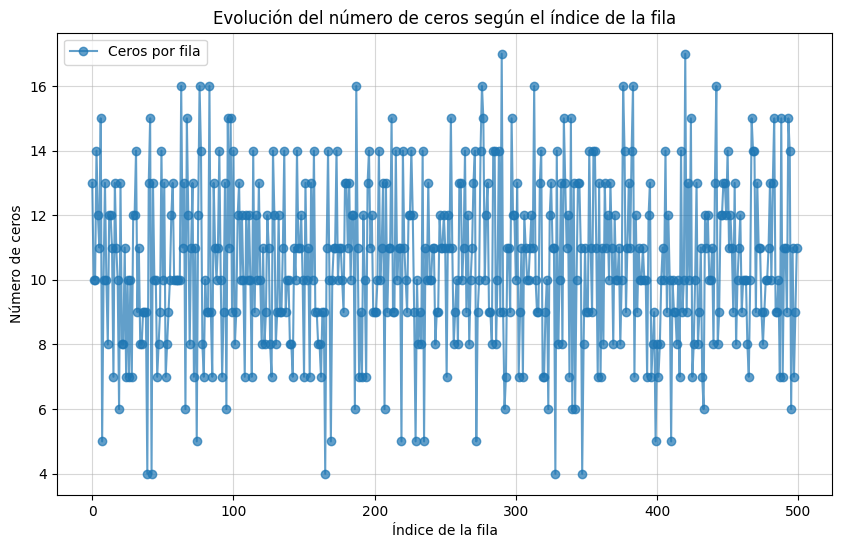

Correlación entre el índice de fila y el número de ceros: 0.03


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_zero_increase(chromosome):
    """
    Analiza cómo cambia el número de ceros en las filas según aumenta el índice de las filas.
    """
    # Calcular el número de ceros por fila
    zeros_per_row = np.sum(chromosome == 0, axis=1)
    
    # Generar índice de fila
    row_indices = np.arange(len(zeros_per_row))
    
    # Visualización
    plt.figure(figsize=(10, 6))
    plt.plot(row_indices, zeros_per_row, marker='o', linestyle='-', alpha=0.7, label="Ceros por fila")
    plt.xlabel("Índice de la fila")
    plt.ylabel("Número de ceros")
    plt.title("Evolución del número de ceros según el índice de la fila")
    plt.grid(alpha=0.5)
    plt.legend()
    plt.show()
    
    # Calcular la correlación entre el índice de fila y el número de ceros
    correlation = np.corrcoef(row_indices, zeros_per_row)[0, 1]
    print(f"Correlación entre el índice de fila y el número de ceros: {correlation:.2f}")
    
    return zeros_per_row, correlation

# Ejemplo de uso
chromosome = np.random.randint(-1, 2, size=(500, 31))  # Generar un cromosoma aleatorio con -1, 0, 1
zeros_per_row, correlation = analyze_zero_increase(chromosome)


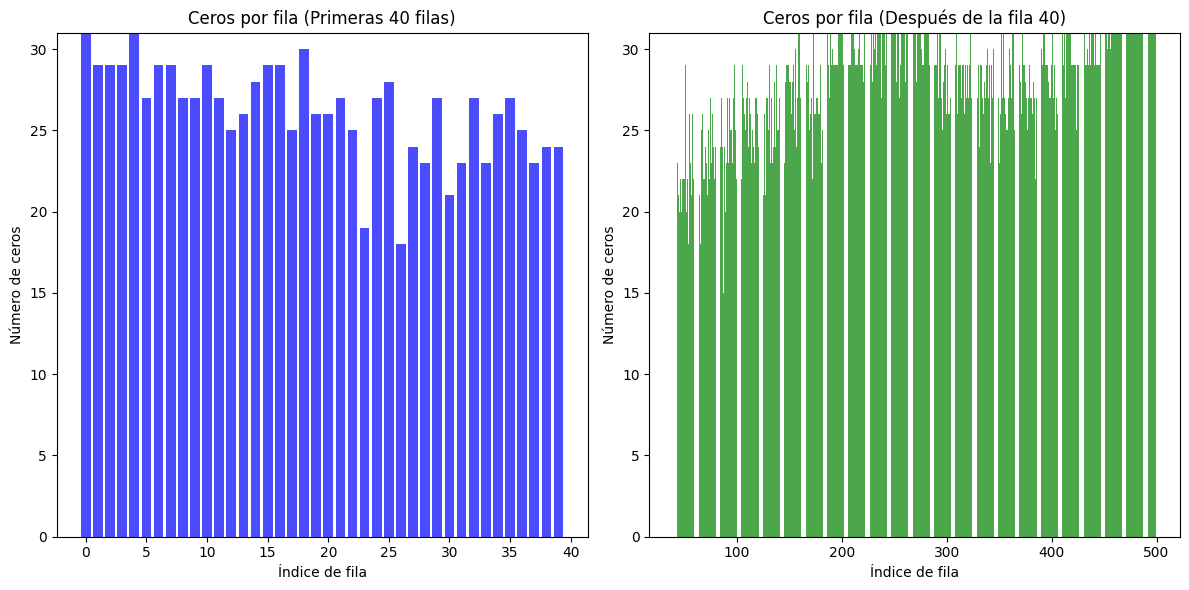

In [5]:
# Dividir el cromosoma en dos partes
f_40 = c[:40, :]  # Primeras 40 filas
after_40 = c[40:, :]  # Resto de las filas

# Calcular la cantidad de ceros en cada parte
zeros_per_row_f40 = np.sum(f_40 == 0, axis=1)
zeros_per_row_after40 = np.sum(after_40 == 0, axis=1)

# Crear el gráfico
plt.figure(figsize=(12, 6))

# Gráfico para las primeras 40 filas
plt.subplot(1, 2, 1)
plt.bar(range(40), zeros_per_row_f40, color='blue', alpha=0.7)
plt.title("Ceros por fila (Primeras 40 filas)")
plt.xlabel("Índice de fila")
plt.ylabel("Número de ceros")
plt.ylim(0, c.shape[1])  # Límite en y igual al número de columnas

# Gráfico para las filas después de la 40
plt.subplot(1, 2, 2)
plt.bar(range(40, c.shape[0]), zeros_per_row_after40, color='green', alpha=0.7)
plt.title("Ceros por fila (Después de la fila 40)")
plt.xlabel("Índice de fila")
plt.ylabel("Número de ceros")
plt.ylim(0, c.shape[1])  # Límite en y igual al número de columnas

plt.tight_layout()
plt.show()


In [20]:
january = generate_dataset().drop(columns=['Date'])

In [21]:
population = [generate_chromosome(january=january,n_assets=500) for i in range(200)]

# MUTATION

In [ ]:
def swap_mutation(chromosome): # No es factible
    n_assets, n_days = chromosome.shape
    asset = np.random.randint(0, n_assets)  # Elegir un activo aleatorio
    day1, day2 = np.random.choice(n_days, 2, replace=False)  # Elegir dos días diferentes
    chromosome[asset, day1], chromosome[asset, day2] = chromosome[asset, day2], chromosome[asset, day1]
    return chromosome


In [13]:
c_muted = swap_mutation(c)

In [23]:
print(check_chromosome(january,population[199]))

True


In [25]:
c = population[199]

In [ ]:
def mutate_chromosome(chromosome, january):
    """
    Realiza una mutación en el cromosoma cambiando un valor por otro permitido en el mismo índice.
    
    Parameters:
    - chromosome: matriz que representa las decisiones de compra/venta/holdear.
    - january: DataFrame con los precios de los activos (sin columna de fecha).
    
    Returns:
    - chromosome: el cromosoma mutado.
    """
    # Elegir un activo y un día aleatorios
    n_assets, n_days = chromosome.shape
    asset = np.random.randint(0, n_assets)  # Índice del activo
    day = np.random.randint(0, n_days)  # Índice del día
    
    # Precio del activo seleccionado en el día específico
    asset_price = january.iloc[day, asset]
    
    # Calcular cuántas acciones se tienen hasta este día
    stocks_held = np.sum(chromosome[asset, :day + 1])  # Acciones acumuladas hasta el día actual

    # Si es una venta (valor negativo), ajustar a un valor permitido
    if chromosome[asset, day] < 0:
        if stocks_held > 0:  # Solo podemos vender si tenemos acciones
            max_sell = stocks_held  # Máximo que podemos vender
            chromosome[asset, day] = -np.random.randint(1, max_sell + 1)  # Reasignar venta
        else:
            chromosome[asset, day] = 0  # No se puede vender, cambiar a holdear
    # Si es un hold (valor 0), no hacemos nada
    else:
        pass

    return chromosome
